In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## NN, Downsample train, NAICS only embedding
Do the embedding model again but downsample training.  This is a baseline for comparing random vs. the custom data generator

Use the dataset with no missing values. 

*This script takes about 15 minutes on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model

## Input Data, Downsample Train

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('20_DATA_downsamp_train.parquet'))

In [7]:
sba_loans['dset'].value_counts()

dset
test     153048
val       95604
train     44684
Name: count, dtype: int64

In [8]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [9]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

{'NAICS': 1170,
 'NAICS_5': 764,
 'NAICS_4': 345,
 'NAICS_3': 107,
 'NAICS_sector': 21}

##### Features

In [10]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [11]:
# NAICS feature 
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [12]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 107, 21]
[8, 4, 4, 2]


##### Datasets for train, validation

In [13]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric].set_index('LoanNr_ChkDgt').sort_index()

In [14]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (44684, 10), y:(44684,)


In [15]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [16]:
base_thresh = y_train.mean()
print(base_thresh)

0.20295855339718916


In [17]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [18]:
X_naics_train = [Xn[Xn['dset'] == 'train'].drop(columns='dset') for Xn in X_naics]
X_naics_val =  [Xn[Xn['dset'] == 'val'].drop(columns='dset') for Xn in X_naics]

## Create, fit model

In [19]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-20 13:47:54.537691: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-20 13:47:54.537748: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-20 13:47:54.537763: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-20 13:47:54.537822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 13:47:54.537842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_01 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_02 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                            

In [21]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [22]:
this_history = this_model.fit([X_train] + X_naics_train, y_train,
                              validation_data=([X_val] + X_naics_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs,
                              callbacks=[callback])

Epoch 1/20


2024-05-20 13:47:56.000263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1397/1397 [==============================] - ETA: 0s - loss: 0.4830 - auc: 0.2919 - auc_1: 0.6574

2024-05-20 13:48:40.483158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1397/1397 [==============================] - 80s 55ms/step - loss: 0.4830 - auc: 0.2919 - auc_1: 0.6574 - val_loss: 0.4628 - val_auc: 0.3412 - val_auc_1: 0.7048
Epoch 2/20
1397/1397 [==============================] - 78s 56ms/step - loss: 0.4646 - auc: 0.3353 - auc_1: 0.6990 - val_loss: 0.4607 - val_auc: 0.3491 - val_auc_1: 0.7081
Epoch 3/20
1397/1397 [==============================] - 84s 60ms/step - loss: 0.4591 - auc: 0.3481 - auc_1: 0.7104 - val_loss: 0.4661 - val_auc: 0.3501 - val_auc_1: 0.7066
Epoch 4/20
1397/1397 [==============================] - 85s 61ms/step - loss: 0.4566 - auc: 0.3556 - auc_1: 0.7151 - val_loss: 0.4626 - val_auc: 0.3501 - val_auc_1: 0.7078
Epoch 5/20
1397/1397 [==============================] - 82s 59ms/step - loss: 0.4537 - auc: 0.3634 - auc_1: 0.7203 - val_loss: 0.4629 - val_auc: 0.3517 - val_auc_1: 0.7082


In [23]:
this_history_df = sbnn_model.process_history(this_history)

In [24]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('23_REPORT_fit_history.csv'))

<Axes: >

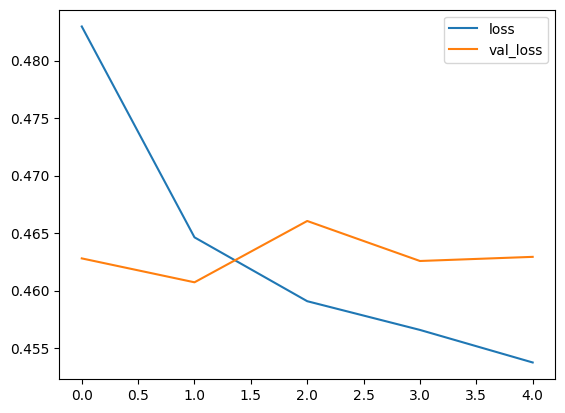

In [25]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

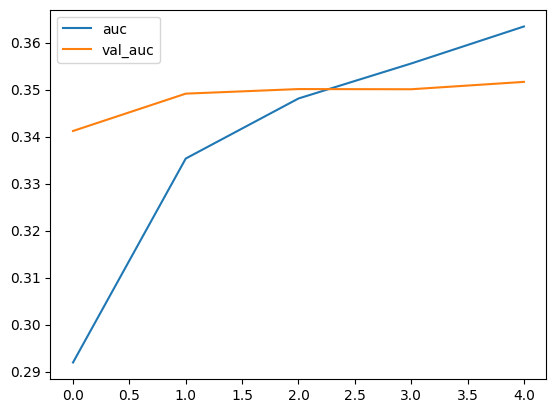

In [26]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

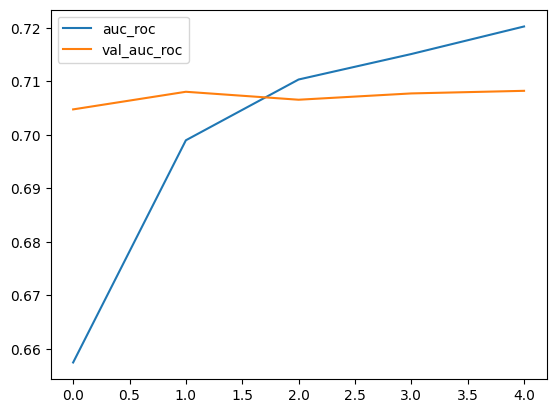

In [27]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [28]:
this_model.save(Path(setup.temp_path).joinpath('23_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [29]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [30]:
all_predictions = this_model.predict([X.drop(columns='dset')] +
                                     [Xn.drop(columns='dset') for Xn in X_naics])

  13/9167 [..............................] - ETA: 40s  

2024-05-20 13:54:47.886977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9167/9167 [==============================] - 51s 6ms/step


In [31]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [32]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.296084
target,0.296084,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [33]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [34]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [35]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
9,0.18,0.455452
10,0.20,0.455395
8,0.16,0.450364


In [36]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.18

##### Append binary predictions to probability predictions

In [37]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [38]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.524337
1    0.475663
Name: proportion, dtype: float64

In [39]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('23_DATA_predictions.parquet'))

## Metrics

In [40]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('23_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.613605,0.437802,0.309835,0.745854,0.346552,0.709198,NaN
1,train,0.636850,0.455452,0.327352,0.748263,0.381655,0.734007,NaN
2,val,0.622809,0.436274,0.313700,0.716067,0.351811,0.708278,NaN
0,test,0.624088,0.434716,0.312984,0.711409,0.346789,0.704898,0.0
1,test,0.596180,0.442513,0.305231,0.804224,0.348779,0.719503,1.0
